In [ ]:
#Import necessary Libraries
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [ ]:
#Amazon stock prices dataset
stock_ticker = input()
start = pd.to_datetime(['2014-09-25']).astype(int)[0]//10**9 # convert to unix timestamp.
end = pd.to_datetime(['2022-04-01']).astype(int)[0]//10**9 # convert to unix timestamp.
url = 'https://query1.finance.yahoo.com/v7/finance/download/' + stock_ticker + '?period1=' + str(start) + '&period2=' + str(end) + '&interval=1d&events=history'
df = pd.read_csv(url)
df

AMZN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  This is separate from the ipykernel package so we can avoid doing imports until


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-25,327.989990,328.540009,321.399994,321.929993,321.929993,2928800
1,2014-09-26,320.600006,323.500000,317.640015,323.209991,323.209991,3638000
2,2014-09-29,320.500000,323.750000,319.000000,321.820007,321.820007,1924600
3,2014-09-30,321.359985,323.429993,318.510010,322.440002,322.440002,2636200
4,2014-10-01,322.040009,322.170013,315.549988,317.459991,317.459991,3089100
...,...,...,...,...,...,...,...
1888,2022-03-25,3280.000000,3307.370117,3245.000000,3295.469971,3295.469971,2451600
1889,2022-03-28,3299.500000,3380.750000,3298.000000,3379.810059,3379.810059,2992700
1890,2022-03-29,3407.679932,3416.629883,3357.370117,3386.300049,3386.300049,3307700
1891,2022-03-30,3370.189941,3379.010010,3310.000000,3326.020020,3326.020020,2808400


In [ ]:
df_close = df['Close']

In [ ]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [ ]:
df_close.shape

(1893, 1)

In [ ]:
#Splitting the data into train and test split
training_size = int(len(df_close) * 0.80)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [ ]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [ ]:
#Reshape the input to be [samples, time steps, features] for LSTM
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [ ]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [ ]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 20, batch_size = 64, verbose = 1)

Epoch 1/20
23/23 [==============================] - 19s 808ms/step - loss: 6.8521e-04 - val_loss: 0.0020
Epoch 2/20
23/23 [==============================] - 14s 626ms/step - loss: 5.2438e-04 - val_loss: 0.0025
Epoch 3/20
23/23 [==============================] - 13s 559ms/step - loss: 5.1984e-04 - val_loss: 0.0025
Epoch 4/20
23/23 [==============================] - 15s 647ms/step - loss: 5.5696e-04 - val_loss: 0.0024
Epoch 5/20
23/23 [==============================] - 9s 381ms/step - loss: 5.0009e-04 - val_loss: 0.0023
Epoch 6/20
23/23 [==============================] - 8s 368ms/step - loss: 5.2445e-04 - val_loss: 0.0026
Epoch 7/20
23/23 [==============================] - 9s 370ms/step - loss: 4.7937e-04 - val_loss: 0.0019
Epoch 8/20
23/23 [==============================] - 9s 412ms/step - loss: 5.0052e-04 - val_loss: 0.0020
Epoch 9/20
23/23 [==============================] - 10s 424ms/step - loss: 4.7716e-04 - val_loss: 0.0018
Epoch 10/20
23/23 [==============================] - 9s 375

In [ ]:

train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [ ]:
#Transform back to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [ ]:
#Calculate RMSE performance metrics
math.sqrt(mean_squared_error(y_train, train_predict))

1429.7526593101938

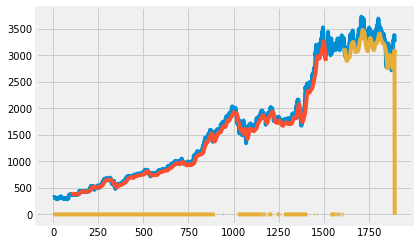

In [ ]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [ ]:
print(test_predict)

[[3138.0989]
 [3124.6597]
 [3106.0535]
 [3084.2676]
 [3062.7056]
 [3041.582 ]
 [3019.0554]
 [2994.7683]
 [2970.3215]
 [2945.532 ]
 [2924.6475]
 [2908.7966]
 [2899.8591]
 [2896.8323]
 [2898.3196]
 [2903.297 ]
 [2911.9148]
 [2919.9878]
 [2927.4946]
 [2935.1768]
 [2943.7976]
 [2951.69  ]
 [2957.0469]
 [2959.6992]
 [2960.6216]
 [2959.7734]
 [2958.728 ]
 [2960.0813]
 [2966.245 ]
 [2976.9626]
 [2992.816 ]
 [3013.138 ]
 [3038.5   ]
 [3067.5093]
 [3098.7703]
 [3128.253 ]
 [3155.4048]
 [3179.9702]
 [3200.608 ]
 [3215.7617]
 [3226.2378]
 [3231.0283]
 [3231.7354]
 [3231.6157]
 [3232.1082]
 [3234.9534]
 [3240.6008]
 [3248.4194]
 [3255.0198]
 [3257.0076]
 [3252.662 ]
 [3243.6877]
 [3231.153 ]
 [3213.398 ]
 [3192.612 ]
 [3168.3838]
 [3142.4395]
 [3118.3481]
 [3099.1777]
 [3084.6118]
 [3074.3691]
 [3068.3977]
 [3064.7056]
 [3063.6812]
 [3065.319 ]
 [3069.291 ]
 [3073.8872]
 [3078.112 ]
 [3081.383 ]
 [3084.0176]
 [3084.6816]
 [3083.9368]
 [3081.931 ]
 [3081.0725]
 [3082.457 ]
 [3088.2107]
 [3097.9824]

In [ ]:
lstm_pred_df = pd.DataFrame(data = test_predict)
lstm_pred_df.columns = ["lstm predicted prices"]
lstm_pred_df



,lstm predicted prices
0,3138.098877
1,3124.659668
2,3106.053467
3,3084.267578
4,3062.705566
...,...
273,2914.204346
274,2961.880859
275,3007.821045
276,3052.493408


#### storing predicted prices into csv

In [ ]:
lstm_pred_df.to_csv('lstm.csv')